# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Load Data

In [2]:
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: c:\Users\hp\Desktop\Truedigital\dsi_submission\project2_Bangkok_Housing\code


In [3]:
# Read file
train_df = pd.read_csv('../data/lasso_train_cleaned.csv')
test_df = pd.read_csv('../data/lasso_test_cleaned.csv')

# Feature Selection before Modeling

In [4]:
train_df.dtypes

id                           int64
province                    object
district                    object
subdistrict                 object
address                     object
property_type               object
total_units                float64
bedrooms                   float64
baths                      float64
floor_area                   int64
floor_level                float64
land_area                  float64
latitude                   float64
longitude                  float64
nearby_stations              int64
nearby_station_distance     object
nearby_bus_stops           float64
nearby_supermarkets        float64
nearby_shops                 int64
year_built                   int64
month_built                 object
facilities                  object
price                        int64
dtype: object

Review features from correlation

In [5]:
train_df.corr(numeric_only=True)

,id,total_units,bedrooms,baths,floor_area,floor_level,land_area,latitude,longitude,nearby_stations,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,price
id,1.000000,-0.014614,0.042419,0.021582,0.033243,-0.023469,-0.067067,0.015760,-0.008652,-0.069821,-0.024025,-0.033559,-0.058276,0.015243,-0.052895
total_units,-0.014614,1.000000,-0.154466,-0.159033,-0.167771,0.165801,0.092614,0.047758,-0.046916,0.017187,0.072876,-0.040342,-0.027835,0.035619,-0.249891
bedrooms,0.042419,-0.154466,1.000000,0.846979,0.842437,-0.110850,-0.435591,0.104163,0.021218,-0.489892,-0.303805,-0.396191,-0.484182,0.046348,0.219909
baths,0.021582,-0.159033,0.846979,1.000000,0.842361,-0.108699,-0.385339,0.089867,0.041890,-0.449122,-0.266494,-0.349300,-0.425398,0.036559,0.305439
floor_area,0.033243,-0.167771,0.842437,0.842361,1.000000,-0.104655,-0.305885,0.103955,0.042438,-0.450853,-0.280343,-0.353734,-0.426330,0.001813,0.328976
floor_level,-0.023469,0.165801,-0.110850,-0.108699,-0.104655,1.000000,0.070289,-0.016651,-0.080406,0.209035,0.048372,0.073446,0.127727,0.063481,0.143172
land_area,-0.067067,0.092614,-0.435591,-0.385339,-0.305885,0.070289,1.000000,-0.047238,-0.002527,0.318805,0.160154,0.241521,0.303863,-0.056684,0.196267
latitude,0.015760,0.047758,0.104163,0.089867,0.103955,-0.016651,-0.047238,1.000000,-0.430913,-0.061262,0.041502,-0.127804,-0.116483,0.014085,-0.056736
longitude,-0.008652,-0.046916,0.021218,0.041890,0.042438,-0.080406,-0.002527,-0.430913,1.000000,-0.146109,0.008175,-0.008212,-0.038912,-0.005811,0.037399
nearby_stations,-0.069821,0.017187,-0.489892,-0.449122,-0.450853,0.209035,0.318805,-0.061262,-0.146109,1.000000,0.128878,0.408774,0.563862,-0.002760,0.255234


In [6]:
feat_num = ['floor_area', 'bedrooms', 'baths', 'floor_level', 'land_area', 'nearby_stations']
feat_cat = ['property_type', 'subdistrict']

train_df[feat_num + feat_cat].info() # check non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13693 entries, 0 to 13692
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   floor_area       13693 non-null  int64  
 1   bedrooms         13693 non-null  float64
 2   baths            13693 non-null  float64
 3   floor_level      13693 non-null  float64
 4   land_area        13693 non-null  float64
 5   nearby_stations  13693 non-null  int64  
 6   property_type    13693 non-null  object 
 7   subdistrict      13693 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 855.9+ KB


#### Train - dev Split

In [7]:
X = pd.get_dummies(train_df[feat_num + feat_cat], columns=feat_cat, drop_first=True)
y = train_df['price']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size=0.8, random_state=42)

# Modelling

## Linear Regression

In [8]:
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_dev_scale = ss.transform(X_dev)

In [9]:
# Instantiate the model
lr=LinearRegression()

In [10]:
#Fit the model
lr.fit(X_train_scale, y_train)

LinearRegression()

In [11]:
pred_train = lr.predict(X_train_scale)
pred_dev = lr.predict(X_dev_scale)

print(mean_squared_error(y_train, pred_train, squared=False))
print(mean_squared_error(y_dev, pred_dev, squared=False))

1195338.3066898496
3.0592673739688068e+16


In [12]:
lr.coef_

array([ 7.29964592e+05,  4.53626124e+05,  7.54798786e+05,  2.04476854e+05,
        2.32582364e+05,  3.95999511e+05, -5.61080222e+04, -4.60628111e+05,
        3.85703524e+04,  1.55807591e+04,  2.72468450e+04, -2.95308601e+04,
        4.31407305e+04,  8.05108859e+03,  4.89450348e+04,  4.10478868e+03,
       -1.50771542e+04, -5.93136370e+04,  2.66616244e+05,  1.61142468e+04,
       -2.15407404e+04,  8.03384612e+03,  1.23345744e+03,  4.85714355e+04,
        2.55675552e+05, -1.37130346e+03, -3.97488036e+03,  3.62629133e+04,
        2.30820713e+04,  1.53900138e+05,  1.60684079e+04,  1.06443801e+05,
       -7.92913482e+03, -4.61367608e+04,  7.34975097e+03,  4.80546872e+04,
        1.69549781e+03,  3.98917430e+04,  1.89014323e+04,  7.49737176e+17,
       -2.60526723e+03, -1.04912797e+03,  2.40936351e+04,  8.49011754e+04,
        2.28792628e+04, -5.16004018e+04,  2.66286233e+03,  1.09817803e+04,
        1.48466461e+04,  1.76324843e+05,  2.08079275e+04,  2.21342933e+04,
       -8.70168473e+02,  

In [13]:
lr.intercept_

3986009.935822531

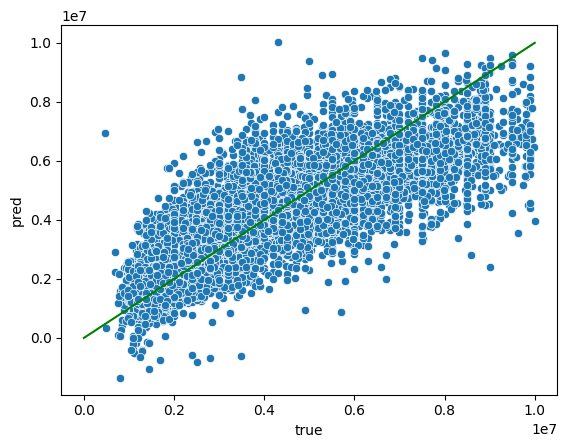

In [14]:
df_result = pd.DataFrame({'true':y_train, 'pred':pred_train})
df_result['residual'] = df_result['pred'] - df_result['true']

sns.scatterplot(y='pred', x='true', data=df_result)
plt.plot(np.linspace(0, 1e7, 100), np.linspace(0, 1e7, 100), color='green');

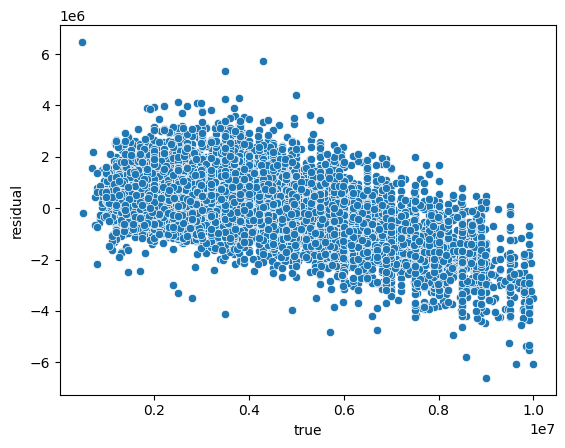

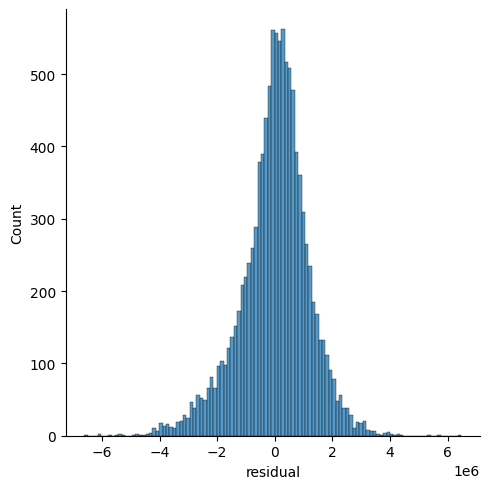

In [15]:
sns.scatterplot(x='true', y='residual', data=df_result)
sns.displot(x='residual', data=df_result);

In [16]:
# Linear Regression coefficients table
coef = pd.DataFrame({'variable':X.columns, 'coef':lr.coef_})
coef.sort_values(by='coef', ascending=False).head(10)

,variable,coef
186,subdistrict_Talat,1.414693e+18
39,subdistrict_Bang Ko Bua,7.497372e+17
2,baths,7.547988e+05
0,floor_area,7.299646e+05
104,subdistrict_Khlong Tan Nuea,7.003624e+05
103,subdistrict_Khlong Tan,5.191166e+05
107,subdistrict_Khlong Toei Nuea,4.683551e+05
1,bedrooms,4.536261e+05
144,subdistrict_Phra Khanong,4.360247e+05
5,nearby_stations,3.959995e+05


In [17]:
# Linear Regression filter out the cofficient of the features that are not subdistrict
coef[coef['variable'].str.contains('subdistrict')]
coef[~coef['variable'].str.contains('subdistrict')]
coef[~coef['variable'].str.contains('subdistrict')].sort_values(by='coef', ascending=False).round(2)

,variable,coef
2,baths,754798.79
0,floor_area,729964.59
1,bedrooms,453626.12
5,nearby_stations,395999.51
4,land_area,232582.36
3,floor_level,204476.85
6,property_type_Detached House,-56108.02
7,property_type_Townhouse,-460628.11


In [18]:
# Linear Regression filter out the cofficient subdistrict
coef[coef['variable'].str.contains('subdistrict')]
coef[coef['variable'].str.contains('subdistrict')].sort_values(by='coef', ascending=False).head(10)

,variable,coef
186,subdistrict_Talat,1.414693e+18
39,subdistrict_Bang Ko Bua,7.497372e+17
104,subdistrict_Khlong Tan Nuea,7.003624e+05
103,subdistrict_Khlong Tan,5.191166e+05
107,subdistrict_Khlong Toei Nuea,4.683551e+05
144,subdistrict_Phra Khanong,4.360247e+05
162,subdistrict_Sam Sen Nai,3.616396e+05
91,subdistrict_Huai Khwang,3.547021e+05
145,subdistrict_Phra Khanong Nuea,3.540139e+05
83,subdistrict_Chom Phon,3.083231e+05


## Lasso Regression Model (Tuning from Linear Regression)

In [19]:
# Instantiate the model
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score

lasso_cv = LassoCV(cv=5, max_iter=1000,random_state=42)
lasso_cv.fit(X_train_scale, y_train)

r_alpha = lasso_cv.alpha_
lasso_model = Lasso(alpha=r_alpha, max_iter=1000, random_state=42)
lasso_model.fit(X_train_scale, y_train)

# R2 score
print(lasso_model.score(X_train_scale, y_train))
print(lasso_model.score(X_dev_scale, y_dev))

pred_train = lasso_model.predict(X_train_scale)
pred_dev = lasso_model.predict(X_dev_scale)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_dev_lasso = np.sqrt(mean_squared_error(y_dev, pred_dev))
print(rmse_train_lasso)
print(rmse_dev_lasso)

0.6927583216807748
0.6784129606365472
1195722.9171209813
1201882.6051150095


In [20]:
# Calculate R2 score for training data
r2_train = r2_score(y_train, pred_train)

# Calculate R2 score for development data
r2_dev = r2_score(y_dev, pred_dev)

# Print the R2 scores
print("R-squared (R2) Score for training data:", r2_train)
print("R-squared (R2) Score for development data:", r2_dev)

R-squared (R2) Score for training data: 0.6927583216807748
R-squared (R2) Score for development data: 0.6784129606365472


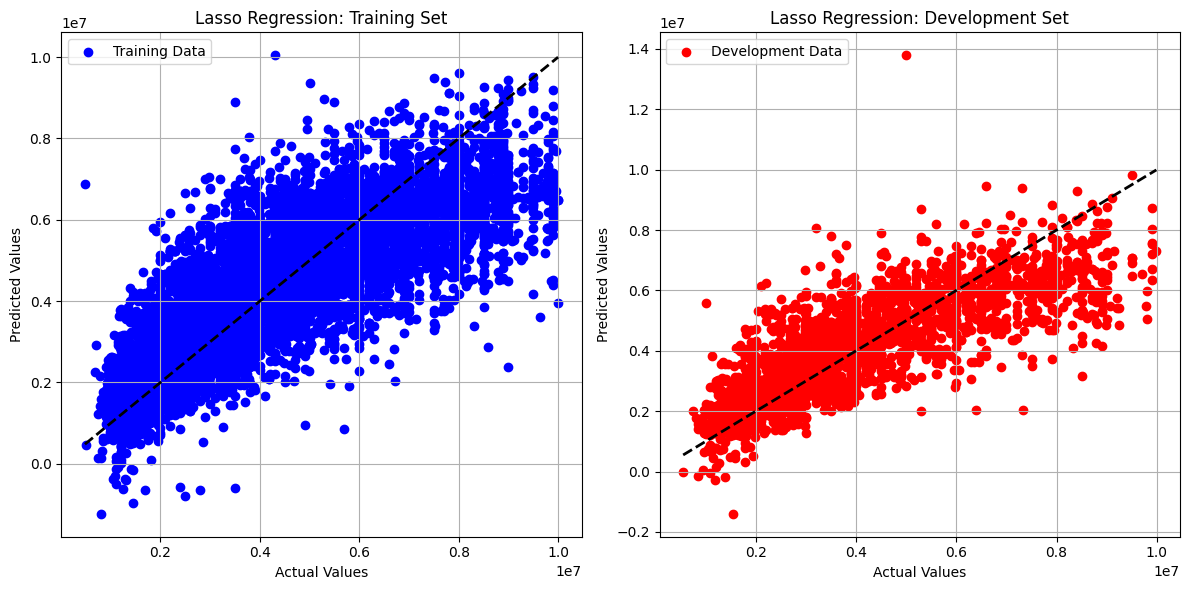

In [21]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot the predicted vs. actual values for the training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, pred_train, c='b', marker='o', label='Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression: Training Set')
plt.legend(loc='upper left')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', lw=2, color='k')
plt.grid(True)

# Plot the predicted vs. actual values for the development set
plt.subplot(1, 2, 2)
plt.scatter(y_dev, pred_dev, c='r', marker='o', label='Development Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression: Development Set')
plt.legend(loc='upper left')
plt.plot([min(y_dev), max(y_dev)], [min(y_dev), max(y_dev)], linestyle='--', lw=2, color='k')
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Selected Feature in Test Data
feat_num = ['floor_area', 'bedrooms', 'baths', 'floor_level', 'land_area', 'nearby_stations']
feat_cat = ['property_type', 'subdistrict']

test_df[feat_num + feat_cat].info() # check non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   floor_area       2500 non-null   int64  
 1   bedrooms         2500 non-null   float64
 2   baths            2500 non-null   float64
 3   floor_level      2500 non-null   float64
 4   land_area        2500 non-null   float64
 5   nearby_stations  2500 non-null   int64  
 6   property_type    2500 non-null   object 
 7   subdistrict      2500 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 156.4+ KB


In [23]:
X_test_imputed = pd.get_dummies(test_df[feat_num + feat_cat], columns=feat_cat, drop_first=True)
X_test_imputed, _ = X_test_imputed.align(X_train, join='right', axis=1, fill_value=0)
# Align Test data and dummify

In [24]:
X_test_imputed

,floor_area,bedrooms,baths,floor_level,land_area,nearby_stations,property_type_Detached House,property_type_Townhouse,subdistrict_Anusawari,subdistrict_Arun Amarin,...,subdistrict_Thung Song Hong,subdistrict_Thung Wat Don,subdistrict_Wang Mai,subdistrict_Wang Thonglang,subdistrict_Wat Arun,subdistrict_Wat Chalo,subdistrict_Wat Phraya Krai,subdistrict_Wat Tha Phra,subdistrict_Wong Sawang,subdistrict_Yan Nawa
0,120,4.0,3.0,11.0,140.000000,0,True,False,0,False,...,False,False,False,False,0,False,False,False,False,False
1,188,4.0,3.0,11.0,208.000000,0,True,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2,22,1.0,1.0,23.0,151.491082,3,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
3,41,1.0,1.0,5.0,151.491082,1,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
4,29,1.0,1.0,25.0,151.491082,0,False,False,0,False,...,True,False,False,False,0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,33,1.0,1.0,12.0,151.491082,2,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2496,65,1.0,1.0,33.0,151.491082,3,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2497,42,1.0,1.0,10.0,151.491082,1,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2498,28,1.0,1.0,8.0,151.491082,1,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False


In [25]:
# Replace randomly 3 to 30 from 0
X_test_imputed.loc[X_test_imputed['floor_level'] == 0,['floor_level']] = np.random.randint(3,30)
X_test_imputed

,floor_area,bedrooms,baths,floor_level,land_area,nearby_stations,property_type_Detached House,property_type_Townhouse,subdistrict_Anusawari,subdistrict_Arun Amarin,...,subdistrict_Thung Song Hong,subdistrict_Thung Wat Don,subdistrict_Wang Mai,subdistrict_Wang Thonglang,subdistrict_Wat Arun,subdistrict_Wat Chalo,subdistrict_Wat Phraya Krai,subdistrict_Wat Tha Phra,subdistrict_Wong Sawang,subdistrict_Yan Nawa
0,120,4.0,3.0,11.0,140.000000,0,True,False,0,False,...,False,False,False,False,0,False,False,False,False,False
1,188,4.0,3.0,11.0,208.000000,0,True,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2,22,1.0,1.0,23.0,151.491082,3,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
3,41,1.0,1.0,5.0,151.491082,1,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
4,29,1.0,1.0,25.0,151.491082,0,False,False,0,False,...,True,False,False,False,0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,33,1.0,1.0,12.0,151.491082,2,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2496,65,1.0,1.0,33.0,151.491082,3,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2497,42,1.0,1.0,10.0,151.491082,1,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False
2498,28,1.0,1.0,8.0,151.491082,1,False,False,0,False,...,False,False,False,False,0,False,False,False,False,False


In [26]:
# transform
X_test_scale = ss.transform(X_test_imputed)
X_test_scale

array([[ 0.75660753,  2.08998792,  1.78259965, ..., -0.04685927,
        -0.0620401 , -0.06350588],
       [ 1.90945604,  2.08998792,  1.78259965, ..., -0.04685927,
        -0.0620401 , -0.06350588],
       [-0.90485063, -0.81678299, -0.7251505 , ..., -0.04685927,
        -0.0620401 , -0.06350588],
       ...,
       [-0.56577754, -0.81678299, -0.7251505 , ..., -0.04685927,
        -0.0620401 , -0.06350588],
       [-0.8031287 , -0.81678299, -0.7251505 , ..., -0.04685927,
        -0.0620401 , -0.06350588],
       [-0.76922139, -0.81678299, -0.7251505 , ..., -0.04685927,
        -0.0620401 , -0.06350588]])

In [27]:
# Apply Lasso Regression Model with test data
test_predictions = lasso_model.predict(X_test_scale)
np.shape(test_predictions)

(2500,)

In [28]:
test_predictions

array([5234664.37714125, 6427082.28544769, 4604285.68152949, ...,
       2682719.55767065, 1824622.0954518 , 2403905.94084347])

In [29]:
test_df[feat_num].corr(numeric_only=True)

,floor_area,bedrooms,baths,floor_level,land_area,nearby_stations
floor_area,1.000000,0.792895,0.788889,-0.107787,0.187623,-0.433207
bedrooms,0.792895,1.000000,0.839625,-0.121548,0.079898,-0.483505
baths,0.788889,0.839625,1.000000,-0.114261,0.077647,-0.453612
floor_level,-0.107787,-0.121548,-0.114261,1.000000,0.010812,0.243998
land_area,0.187623,0.079898,0.077647,0.010812,1.000000,-0.008995
nearby_stations,-0.433207,-0.483505,-0.453612,0.243998,-0.008995,1.000000


In [30]:
test_df['price'] = test_predictions
test_df

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price
0,10317868,Samut Prakan,Bang Phli,Bang Phli Yai,Nam Daeng Road Yai,Detached House,800.0,4.0,3.0,120,...,100.680610,0,Unknown,14.254386,9.0,5,2015,May,"['Clubhouse', 'Community Garden', 'CCTV', 'Pav...",5.234664e+06
1,10885829,Bangkok,Nong Khaem,Nong Khang Phlu,Machareon Road,Detached House,107.0,4.0,3.0,188,...,100.341833,0,Unknown,20.000000,9.0,5,2020,April,"['Car Park', 'Clubhouse', 'Community Garden', ...",6.427082e+06
2,10765951,Bangkok,Huai Khwang,Huai Khwang,72 Rama 9,Condo,433.0,1.0,1.0,22,...,100.566385,3,"[['BL20 Phra Ram 9 MRT', 270], ['E4 Asok BTS',...",14.254386,13.0,20,2015,September,"['Covered car park', 'CCTV', 'Fitness corner',...",4.604286e+06
3,10003549,Bangkok,Khlong Toei,Khlong Tan,"772 Sukhumvit Road, Khong Tan",Condo,656.0,1.0,1.0,41,...,100.577202,1,"[['E6 Thong Lo BTS', 70]]",20.000000,16.0,20,2013,June,"['Car Park', 'Covered car park', 'CCTV', 'Fitn...",5.637100e+06
4,10663026,Bangkok,Lak Si,Thung Song Hong,222 Ngamwongwan Road,Condo,1458.0,1.0,1.0,29,...,100.547923,0,Unknown,20.000000,10.0,14,2012,September,"['Covered car park', 'CCTV', 'Fitness corner',...",2.066661e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,10889363,Bangkok,Bang Rak,Maha Phruettharam,660-662 Rama 4 Road,Condo,1598.0,1.0,1.0,33,...,100.526269,2,"[['BL27 Sam Yan MRT', 410], ['S2 Sala Daeng BT...",14.254386,18.0,20,2016,September,"['Amphitheatre', 'Covered car park', 'Communit...",5.191368e+06
2496,10975839,Bangkok,Sathon,Thung Maha Mek,88 Narathiwatratchanakharin Road,Condo,493.0,1.0,1.0,65,...,100.531092,3,"[['B1 Sathorn BRT', 180], ['B2 Arkan Songkhro ...",20.000000,20.0,20,2009,July,"['Covered car park', 'CCTV', 'Fitness corner',...",6.614654e+06
2497,10986832,Bangkok,Bang Phlat,Bang Yi Khan,"1521 Soi Arun Amarin 53, Arun Amarin Road",Condo,1121.0,1.0,1.0,42,...,100.492732,1,"[['BL05 Bang Yi Khan MRT', 910]]",14.254386,5.0,7,2009,January,"['Car Park', 'Community Garden', 'CCTV', 'Fitn...",2.682720e+06
2498,10687627,Samut Prakan,Mueang Samut Prakan,Samrong Nuea,Thang Rotfai Sai Kao Road,Condo,719.0,1.0,1.0,28,...,100.592954,1,"[['E15 Samrong BTS', 800]]",19.000000,13.0,20,2016,December,"['Covered car park', 'CCTV', 'Fitness corner',...",1.824622e+06


In [31]:
# Create submission file
submission_project = pd.DataFrame(test_df[['id','price']])
submission_project

,id,price
0,10317868,5.234664e+06
1,10885829,6.427082e+06
2,10765951,4.604286e+06
3,10003549,5.637100e+06
4,10663026,2.066661e+06
...,...,...
2495,10889363,5.191368e+06
2496,10975839,6.614654e+06
2497,10986832,2.682720e+06
2498,10687627,1.824622e+06


In [32]:
submission_project.to_csv('../submission/lasso_submission_model.csv', index=False)

In [33]:
# To answer problem statement
# Find price prediction from 1.5 million to 3.5 million Thai Baht
test_df[(test_df['price'] >= 1500000) & (test_df['price'] <= 3500000)].sort_values(by='price', ascending=True)

# answer: this table shows the property which price prediction from 1.5 million to 3.5 million Thai Baht which is the price range that the potential clients want to buy.
# For example, the property which is in Talat Khwan subdistrict, Nonthaburi province, the price is 1,500,000 Thai Baht.

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price
2023,10967235,Nonthaburi,Mueang Nonthaburi,Talat Khwan,8 Tiwanon Road,Condo,373.0,1.0,1.0,29,...,100.516425,1,"[['PP12 Ministry of Public Health MRT', 280]]",14.254386,6.000000,10,2018,January,"['Car Park', 'Covered car park', 'Clubhouse', ...",1.500094e+06
299,10999476,Nonthaburi,Mueang Nonthaburi,Talat Khwan,8 Tiwanon Road,Condo,373.0,1.0,1.0,29,...,100.516425,1,"[['PP12 Ministry of Public Health MRT', 280]]",14.254386,6.000000,10,2018,January,"['Car Park', 'Covered car park', 'Clubhouse', ...",1.500094e+06
971,11027055,Bangkok,Bueng Kum,Nuan Chan,163 Nawamin Rd,Condo,406.0,1.0,1.0,31,...,100.657240,0,Unknown,20.000000,16.000000,11,2013,July,"['CCTV', 'Fitness corner', '24 hours security'...",1.506183e+06
1066,10860933,Samut Prakan,Bang Phli,Bang Phli Yai,Bangna-Trad Road Yai,Condo,945.0,1.0,1.0,25,...,100.680643,0,Unknown,5.000000,5.000000,10,2015,January,"['Car Park', 'Covered car park', 'CCTV', 'Fitn...",1.511143e+06
2058,10979250,Samut Prakan,Phra Samut Jadee,Nai Khlong Bang Pla Kot,Nai Khlong Bang Pla Kot,Townhouse,713.0,3.0,2.0,74,...,100.540862,0,Unknown,14.254386,9.140431,1,2015,January,[],1.515336e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,10406971,Bangkok,Bang Khae,Bang Khae,เพชรเกษม,Detached House,713.0,2.0,2.0,120,...,100.381099,0,Unknown,17.000000,4.000000,1,2015,November,[],3.491147e+06
1566,10658021,Bangkok,Chatuchak,Chom Phon,296 Ladpao Road,Condo,561.0,1.0,1.0,34,...,100.568151,1,"[['BL15 Lat Phrao MRT', 630]]",14.254386,9.000000,20,2012,May,"['Covered car park', 'CCTV', 'Sauna', '24 hour...",3.492481e+06
2054,7891642,Bangkok,Huai Khwang,Huai Khwang,"Soi Pracharat Bumpan 18, Pracharat Bumpan Road",Condo,167.0,1.0,1.0,38,...,100.581814,1,"[['BL18 Huai Khwang MRT', 930]]",14.254386,20.000000,20,2017,January,"['BBQ pits', 'Car Park', 'Community Garden', '...",3.494080e+06
557,10805256,Samut Prakan,Bang Bo,Ban Rakat,Soi Kiatpipat Thani,Townhouse,713.0,3.0,2.0,140,...,100.607510,0,Unknown,1.000000,15.000000,11,2015,December,"[""Children's Playground"", 'Clubhouse', 'Commun...",3.497584e+06


In [34]:
# Company is looking for property near station, for example, BTS, MRT, ART, and other skytrain stations.
# Find property near station
test_df[test_df['nearby_station_distance'] != 'Unknown'].sort_values(by='nearby_station_distance', ascending=True).head(10)

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price
1266,7595441,Bangkok,Lat Krabang,Khlong Sam Prawet,Rom Klao Road,Condo,1019.0,1.0,1.0,36,...,100.746544,1,"[['A2 Lat Krabang Airport Link', 390]]",14.254386,4.0,2,2012,September,"['Car Park', 'CCTV', 'Fitness corner', 'Gymnas...",8.995698e+05
1053,8684469,Bangkok,Lat Krabang,Khlong Sam Prawet,Rom Klao Road,Condo,1019.0,2.0,1.0,40,...,100.746544,1,"[['A2 Lat Krabang Airport Link', 390]]",14.254386,4.0,2,2012,September,"['Car Park', 'CCTV', 'Fitness corner', 'Gymnas...",1.440758e+06
197,9029282,Bangkok,Lat Krabang,Khlong Sam Prawet,Rom Klao Road,Condo,1019.0,2.0,1.0,40,...,100.746544,1,"[['A2 Lat Krabang Airport Link', 390]]",14.254386,4.0,2,2012,September,"['Car Park', 'CCTV', 'Fitness corner', 'Gymnas...",1.474902e+06
561,8202873,Bangkok,Lat Krabang,Khlong Sam Prawet,Rom Klao Road,Condo,1019.0,1.0,1.0,38,...,100.746544,1,"[['A2 Lat Krabang Airport Link', 390]]",14.254386,4.0,2,2012,September,"['Car Park', 'CCTV', 'Fitness corner', 'Gymnas...",1.094970e+06
494,7846347,Bangkok,Lat Krabang,Khlong Sam Prawet,Rom Klao Road,Condo,1019.0,1.0,1.0,28,...,100.746544,1,"[['A2 Lat Krabang Airport Link', 390]]",14.254386,4.0,2,2012,September,"['Car Park', 'CCTV', 'Fitness corner', 'Gymnas...",8.349896e+05
1746,10928642,Bangkok,Lat Krabang,Khlong Sam Prawet,Rom Klao Road,Condo,1019.0,1.0,1.0,29,...,100.746544,1,"[['A2 Lat Krabang Airport Link', 390]]",14.254386,4.0,2,2012,September,"['Car Park', 'CCTV', 'Fitness corner', 'Gymnas...",9.497615e+05
2333,10782796,Bangkok,Prawet,Prawet,199 Soi On Nut 65,Detached House,111.0,3.0,3.0,134,...,100.690192,1,"[['A3 Ban Thap Chang Airport Link', 670]]",14.254386,7.0,4,2015,March,"[""Children's Playground"", 'Clubhouse', 'Commun...",5.950704e+06
676,10764273,Bangkok,Prawet,Prawet,199 Soi On Nut 65 Yeak 14,Townhouse,416.0,4.0,2.0,113,...,100.690205,1,"[['A3 Ban Thap Chang Airport Link', 680]]",14.254386,7.0,4,2017,September,"['Clubhouse', 'Community Garden', 'CCTV', 'Fit...",4.062267e+06
741,10919926,Bangkok,Prawet,Prawet,Soi On Nut 65 Yak14,Detached House,217.0,4.0,3.0,146,...,100.688130,1,"[['A3 Ban Thap Chang Airport Link', 770]]",14.254386,5.0,4,2017,January,"['Clubhouse', 'Community Garden', 'CCTV', 'Fit...",6.877177e+06
246,10284663,Bangkok,Prawet,Prawet,Chalermprakiat 9 Road,Condo,498.0,1.0,1.0,30,...,100.697440,1,"[['A3 Ban Thap Chang Airport Link', 950]]",14.254386,5.0,4,2016,March,"['Car Park', 'Covered car park', 'CCTV', 'Fitn...",1.809964e+06


In [35]:
# To focus more on the property near station, I found the property which is near station and price prediction from 1.5 million to 3.5 million Thai Baht
test_df[(test_df['nearby_station_distance'] != 'Unknown') & (test_df['price'] >= 1500000) & (test_df['price'] <= 3500000)].sort_values(by='price', ascending=True)

# answer: the cheapest price is approximate 1.5 million Thai Baht in Nonthaburi where near MRT: Ministry of Public Health Station

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price
299,10999476,Nonthaburi,Mueang Nonthaburi,Talat Khwan,8 Tiwanon Road,Condo,373.0,1.0,1.0,29,...,100.516425,1,"[['PP12 Ministry of Public Health MRT', 280]]",14.254386,6.0,10,2018,January,"['Car Park', 'Covered car park', 'Clubhouse', ...",1.500094e+06
2023,10967235,Nonthaburi,Mueang Nonthaburi,Talat Khwan,8 Tiwanon Road,Condo,373.0,1.0,1.0,29,...,100.516425,1,"[['PP12 Ministry of Public Health MRT', 280]]",14.254386,6.0,10,2018,January,"['Car Park', 'Covered car park', 'Clubhouse', ...",1.500094e+06
168,10730667,Nonthaburi,Mueang Nonthaburi,Bang Kraso,Rattanathibet,Condo,633.0,1.0,1.0,29,...,100.469560,1,"[['PP07 Sai Ma MRT', 370]]",14.254386,4.0,3,2014,August,"['CCTV', 'Fitness corner', '24 hours security'...",1.527905e+06
1984,11031603,Samut Prakan,Mueang Samut Prakan,Pak Nam,92 Sukhumvit Road,Condo,1570.0,1.0,1.0,24,...,100.589390,1,"[['E17 Chang Erawan BTS', 150]]",18.000000,8.0,3,2017,December,"['BBQ pits', 'Car Park', 'Community Garden', '...",1.529693e+06
778,10881822,Nonthaburi,Mueang Nonthaburi,Talat Khwan,8 Tiwanon Road,Condo,373.0,1.0,1.0,29,...,100.516425,1,"[['PP12 Ministry of Public Health MRT', 280]]",14.254386,6.0,10,2018,January,"['Car Park', 'Covered car park', 'Clubhouse', ...",1.534237e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,9819580,Bangkok,Huai Khwang,Huai Khwang,ถนน ประชาอุทิศ,Condo,875.0,1.0,1.0,45,...,100.575734,1,"[['BL18 Huai Khwang MRT', 340]]",14.254386,20.0,20,2014,February,"['Covered car park', 'CCTV', 'Fitness corner',...",3.478032e+06
2332,10845195,Bangkok,Bang Na,Bang Na,195 Sanphawut Road,Condo,1569.0,1.0,1.0,27,...,100.604476,2,"[['E13 Bang Na BTS', 570], ['E12 Udom Suk BTS'...",14.254386,6.0,4,2017,January,"['Car Park', 'Covered car park', 'CCTV', 'Fitn...",3.483063e+06
756,10847947,Bangkok,Din Daeng,Din Daeng,Soi Ratchadaphisek 3 Ratchadaphisek Road,Condo,321.0,1.0,1.0,33,...,100.564818,2,"[['BL20 Phra Ram 9 MRT', 570], ['BL19 Thailand...",14.254386,18.0,20,2017,January,"['BBQ pits', 'Basement car park', 'Car Park', ...",3.489724e+06
1566,10658021,Bangkok,Chatuchak,Chom Phon,296 Ladpao Road,Condo,561.0,1.0,1.0,34,...,100.568151,1,"[['BL15 Lat Phrao MRT', 630]]",14.254386,9.0,20,2012,May,"['Covered car park', 'CCTV', 'Sauna', '24 hour...",3.492481e+06


In [36]:
# Where is the most price sensitivity? and where is the least?
# Find the highest price sensitivity and the least price sensitivity near station
test_df[test_df['nearby_station_distance'] != 'Unknown'].sort_values(by='price', ascending=False)

# answer: the highest price sensitivity is in subdistrict: Bangsue where near MRT: Bang Pho Station is approximately 12.5 million Thai Baht

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price
2434,10707811,Bangkok,Bang Sue,Bang Sue,"123,149,155 ประชาราษฎร์ สาย 1 แยก19",Detached House,713.0,10.0,4.0,240,...,100.519641,1,"[['BL09 Bang Pho MRT', 270]]",14.254386,9.0,3,2015,May,[],1.242635e+07
1059,10925585,Bangkok,Chatuchak,Lat Yao,งามวงศ์วาน,Detached House,713.0,4.0,2.0,360,...,100.557741,2,"[['RN03 SRT Wat Samian Nari', 40], ['RN04 SRT ...",20.000000,7.0,12,2015,February,[],1.011813e+07
797,11006127,Bangkok,Watthana,Khlong Toei Nuea,Soi Sukhumvit 15,Condo,500.0,2.0,2.0,101,...,100.558252,3,"[['E3 Nana BTS', 380], ['BL22 Sukhumvit MRT', ...",14.254386,12.0,20,2013,January,"['Car Park', 'Clubhouse', 'CCTV', 'Fitness cor...",8.988875e+06
898,10642918,Bangkok,Chatuchak,Lat Yao,Lat Yao,Detached House,713.0,5.0,3.0,190,...,100.565187,2,"[['RN03 SRT Wat Samian Nari', 790], ['RN04 SRT...",20.000000,7.0,14,2015,September,['Covered car park'],8.909310e+06
169,10976761,Bangkok,Watthana,Khlong Toei Nuea,24 Sukhumvit Road,Condo,228.0,2.0,2.0,100,...,100.562196,3,"[['BL22 Sukhumvit MRT', 170], ['E3 Nana BTS', ...",14.254386,13.0,20,1996,March,"['Covered car park', 'CCTV', 'Fitness corner',...",8.703385e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,11007485,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,24,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",7.010303e+05
243,10942629,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,23,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",5.862584e+05
1837,10717774,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,24,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",5.644551e+05
1002,10942637,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,23,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",5.179708e+05


In [37]:
# answer: the lowest price sensitivity is in subdistrict: Bang Rak Phatthana where near MRT: Bang Phai Station is approximately 510,000 Thai Baht
test_df[test_df['nearby_station_distance'] != 'Unknown'].sort_values(by='price', ascending=True)

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price
1002,10942637,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,23,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",5.179708e+05
735,10941477,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,23,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",5.179708e+05
1837,10717774,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,24,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",5.644551e+05
243,10942629,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,23,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",5.862584e+05
2304,11007485,Nonthaburi,Bang Bua Thong,Bang Rak Phatthana,Janthongeam Road,Condo,1870.0,1.0,1.0,24,...,100.405623,1,"[['PP01 Khlong Bang Phai MRT', 370]]",14.254386,9.0,13,2015,December,"['Covered car park', 'Community Garden', 'CCTV...",7.010303e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10976761,Bangkok,Watthana,Khlong Toei Nuea,24 Sukhumvit Road,Condo,228.0,2.0,2.0,100,...,100.562196,3,"[['BL22 Sukhumvit MRT', 170], ['E3 Nana BTS', ...",14.254386,13.0,20,1996,March,"['Covered car park', 'CCTV', 'Fitness corner',...",8.703385e+06
898,10642918,Bangkok,Chatuchak,Lat Yao,Lat Yao,Detached House,713.0,5.0,3.0,190,...,100.565187,2,"[['RN03 SRT Wat Samian Nari', 790], ['RN04 SRT...",20.000000,7.0,14,2015,September,['Covered car park'],8.909310e+06
797,11006127,Bangkok,Watthana,Khlong Toei Nuea,Soi Sukhumvit 15,Condo,500.0,2.0,2.0,101,...,100.558252,3,"[['E3 Nana BTS', 380], ['BL22 Sukhumvit MRT', ...",14.254386,12.0,20,2013,January,"['Car Park', 'Clubhouse', 'CCTV', 'Fitness cor...",8.988875e+06
1059,10925585,Bangkok,Chatuchak,Lat Yao,งามวงศ์วาน,Detached House,713.0,4.0,2.0,360,...,100.557741,2,"[['RN03 SRT Wat Samian Nari', 40], ['RN04 SRT ...",20.000000,7.0,12,2015,February,[],1.011813e+07


In [38]:
# lasso coefficient table for each feature and subdistrict
coef = pd.DataFrame({'variable':X.columns, 'coef':lasso_model.coef_})
coef.sort_values(by='coef', ascending=False).head(10)

,variable,coef
2,baths,757843.121869
0,floor_area,727896.141702
104,subdistrict_Khlong Tan Nuea,619902.881663
103,subdistrict_Khlong Tan,452988.864750
1,bedrooms,437123.145662
5,nearby_stations,414873.176756
107,subdistrict_Khlong Toei Nuea,408895.689556
144,subdistrict_Phra Khanong,350411.425379
145,subdistrict_Phra Khanong Nuea,285513.380788
162,subdistrict_Sam Sen Nai,283128.245435


In [39]:
# lasso coefficient table for each feature and subdistrict
coef[coef['variable'].str.contains('subdistrict')]
coef[coef['variable'].str.contains('subdistrict')].sort_values(by='coef', ascending=False).head(10)

,variable,coef
104,subdistrict_Khlong Tan Nuea,619902.881663
103,subdistrict_Khlong Tan,452988.864750
107,subdistrict_Khlong Toei Nuea,408895.689556
144,subdistrict_Phra Khanong,350411.425379
145,subdistrict_Phra Khanong Nuea,285513.380788
162,subdistrict_Sam Sen Nai,283128.245435
91,subdistrict_Huai Khwang,265975.077909
197,subdistrict_Thanon Phaya Thai,251048.281905
121,subdistrict_Lumphini,249260.321914
178,subdistrict_Si Phraya,239326.371468


In [40]:
# lasso coefficient table for each feature and subdistrict
coef[coef['variable'].str.contains('subdistrict')]
coef[coef['variable'].str.contains('subdistrict')].sort_values(by='coef', ascending=False).tail(10)

,variable,coef
159,subdistrict_Sai Noi,-67621.097955
33,subdistrict_Bang Khu Rat,-70538.842599
116,subdistrict_Lam Pho,-74138.943780
127,subdistrict_Nai Khlong Bang Pla Kot,-79955.195595
41,subdistrict_Bang Kraso,-82501.854190
142,subdistrict_Phimon Rat,-91117.100770
45,subdistrict_Bang Mae Nang,-92256.903520
60,subdistrict_Bang Pla,-94800.811027
17,subdistrict_Bang Bua Thong,-99063.410915
65,subdistrict_Bang Rak Phatthana,-136423.658948


In [41]:
# lasso coefficient table for each feature and subdistrict
coef[~coef['variable'].str.contains('subdistrict')]
coef[~coef['variable'].str.contains('subdistrict')].sort_values(by='coef', ascending=False)

,variable,coef
2,baths,757843.121869
0,floor_area,727896.141702
1,bedrooms,437123.145662
5,nearby_stations,414873.176756
4,land_area,232809.018409
3,floor_level,203991.864474
6,property_type_Detached House,-61234.976007
7,property_type_Townhouse,-467548.365543
